<a href="https://colab.research.google.com/github/yossy1/mat281_portfolio_2022/blob/master/Taller1_INF395_Galaxies_PUB_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 1

El objetivo de este taller es que se familiarice con conceptos básicos de redes neuronales y con herramientas que le permitan implementar modelos más competitivos más adelante. 



<table align='left'>
<tr>
<td><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/a/a6/Hubble-Space-Telescope-Galaxy-Collection.jpg/700px-Hubble-Space-Telescope-Galaxy-Collection.jpg' width='900'/> </td>
</tr>
</table>

# Base Imports

In [ ]:
from tensorflow import keras
import seaborn as sns; sns.set()
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

from keras.optimizers import Adam
from tensorflow.keras.layers import Dense


# Problema y Datos

Utilizaremos datos provenientes de Galaxy Zoo, un proyecto astronómico internacional en el que cientos de voluntarios no expertos participaron etiquetando imágenes de galaxias de acuerdo a diferentes patrones morfológicos. La versión que utilizaremos ha sido pre-procesada para incluir 10 clases diferentes y el objetivo es poder contar con un programa que en el futuro analice automáticamente grandes volúmenes de imágenes astronómicas para reconocer objetos de interés. 

*Se advierte que este es un problema bastante realista a diferencia de los ejemplos que hemos visto sobre MNIST, Fashion MNIST, o CIFAR, de modo que no es trivial obtener buenos rendimientos. Manténgase resiliente y recuerde que su objetivo en la experiencia es aprender conceptos y "trucos" básicos para más adelante.*



Para descargar los datos usualmente yo me conecto a mi Google Drive, pero usted puede omitir este paso y cargar directamente los archivos distribuidos con la tarea.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving modelo_visual_entrenado (1).h5 to modelo_visual_entrenado (1) (1).h5


In [ ]:
!wget http://www.inf.utfsm.cl/~jnancu/galaxies_INF395-extended.tar

URL transformed to HTTPS due to an HSTS policy
--2023-04-23 20:16:24--  https://www.inf.utfsm.cl/~jnancu/galaxies_INF395-extended.tar
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2706841600 (2.5G) [application/octet-stream]
Saving to: ‘galaxies_INF395-extended.tar.1’

galaxies_INF395-ext 100%[===================>]   2.52G  18.8MB/s    in 2m 21s  

2023-04-23 20:18:46 (18.3 MB/s) - ‘galaxies_INF395-extended.tar.1’ saved [2706841600/2706841600]



Para descomprimir los datos debe incluir la ruta correcta al archivo. Si la cargo manualmente a Colab, estará muy probablemente en /content/

In [ ]:
!tar -xf "/content/galaxies_INF395-extended.tar" --strip-components=1

Notará que los datos han sido divididos en 3 particiones diferentes: entrenamiento (train), validación (val), y pruebas (test). Ya deberá explicar para qué se usa c/u. Por ahora note también que se ha incluido una selección "reduced_train" a utilizar en algunos experimentos en que entrenar sobre el dataset completo es lento.

In [ ]:
!ls galaxies_INF395/

reduced_train  test  train  val


# Instrucciones 

Cada una de las siguientes secciones contiene preguntas que usted deberá abordar en el video explicativo a enviar. Se evaluarán sus respuestas a cada sección (P1, P2, etc) y su nota se calculará como el promedio de todas las secciones.

Para evaluar cada parte se considerará: 

*   Completitud: Se respondió o se hizo lo pedido?
*   Correctitud: Se respondió o se hizo correctamente lo pedido?
*   Profundidad: Se demostró interés, espíritu crítico, espíritu de investigación, y estudio de las materias?
*   Claridad: Se explicó de modo claro y sintético lo realizado, destacando lo relevante sin caer en detalles superfluos?

Fuera de eso, cualquier cosa original que haga fuera de lo pedido sumará puntos.

# P1. Load & Explore

Como punto de partida debe siempre explorar los datos disponibles, determinando de qué cosa se trata, cuántas clases existen, con cuántos cuenta para entrenar o evaluar por c/clase, etc.

* Averigue qué hace la clase tf.keras.utils.image_dataset_from_directory y porqué es conveniente utilizarla para manejar datasets de imágenes en vez de cargar cada una de ellas manualmente.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os

BATCH_SIZE = 32
RES_ESPACIAL = 64
CHANNELS = 3

label_list = []
for class_name in os.listdir("/content/galaxies_INF395/train/"):
  label_list.append(class_name)
label_list.sort()#lexicograficamente

idx2classname = {}
for idx, class_name in enumerate(label_list):
  idx2classname[idx] = class_name

print(idx2classname[0])

def load_data(path,batch_size,res=RES_ESPACIAL):
  return tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(res,res),
    shuffle=True)

train_data = load_data("/content/galaxies_INF395/train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("/content/galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
test_data = load_data("/content/galaxies_INF395/test/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

Disk_Edge-on_Boxy_Bulge
Found 10636 files belonging to 10 classes.
Found 3542 files belonging to 10 classes.
Found 3558 files belonging to 10 classes.


RESPUESTA: La clase tf.keras.utils.image_dataset_from_directory  es una clase de TensorFlow que permite cargar conjuntos de datos de imágenes automáticamente y convertirlos en conjuntos de datos de TensorFlow. Esto es útil porque evita la necesidad de cargar y manipular manualmente cada imagen y sus etiquetas correspondientes. Además, en cuanto a memoria y tiempo de carga resulta se más eficiente, pudiendo procesar grandes conjuntos de datos.

* Determine de cuántos datos de entrenamiento, validación, y pruebas dispone, explicando el rol de c/u de estas particiones. Grafique además el número de datos por clase en cada participación. ¿Nota alguna anomalía que pueda afectar el entrenamiento?

In [ ]:
import pandas as pd

def count_by_class(dataset):
  labels = []
  for (image,label) in dataset:
    labels.append(label.numpy())
  labels_array=np.vstack(labels)
  labels_array=np.argmax(labels_array,axis=1)
  return np.unique(labels_array, return_counts=True)

unique, counts = count_by_class(train_data)

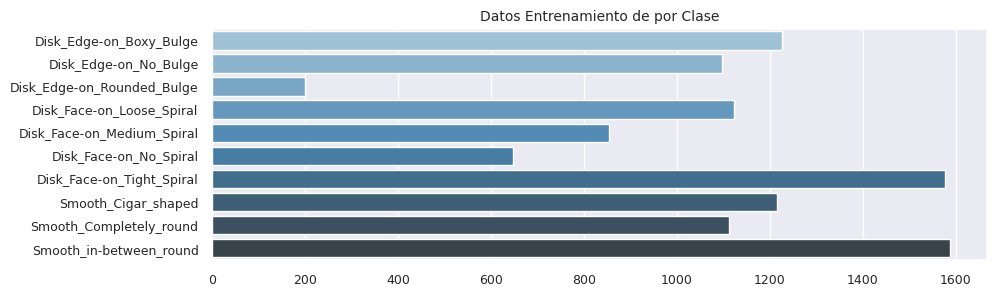

In [ ]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
b = sns.barplot(y=[idx2classname[i] for i in unique], x=counts,ax=ax,palette="Blues_d")#color='m'
b.tick_params(labelsize=9)
ax.set_title('Datos Entrenamiento de por Clase',fontsize=10)
plt.xticks(rotation=0)
plt.show()

RESPUESTA: Algunas clases tienen muchas menos imágenes que otras y viceversa, lo cual puede provocar un desequilibrio en el modelo durante el entrenamiento, afectando su capacidad para generalizar nuevas imágenes. Por otro lado, hay clases con una cantidad excesiva de imágenes en comparación con otras, lo cual podría traducirse en un sobreajustamiento o un sesgo hacia esas clases en particular, lo que también podría afectar su capacidad para generalizar nuevas imágenes.

* Determine si las imágenes son a color o en blanco y negro, explorando el número de canales de las mismas. Visualice 10 imágenes aleatorias y comente la forma de las clases de galaxias observadas.

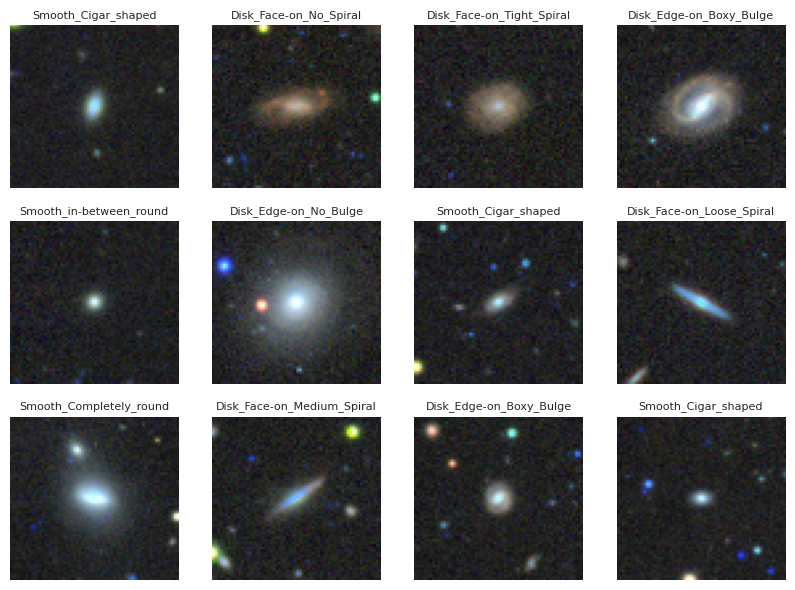

In [ ]:
showme = 10
size = 10
counter = 0
fig = plt.figure('Ejemplos', figsize=[size,size*10/4]) 
for image, label in train_data.unbatch():
  class_name = idx2classname[np.argmax(label.numpy())]
  im = image.numpy()/255.0
  fig.add_subplot(10, 4, counter+1) 
  plt.imshow(im,aspect='auto')
  plt.grid(None) 
  plt.axis('off')
  plt.title(class_name,fontsize=8) 
  if counter>showme:
    break
  counter+=1
plt.show()

# P2. Modelo Base

El objetivo de esta sección es que aprenda a definir una red y a entrenarla diagnósticando el resultado con las herramientas adecuadas. Por el lado más práctico, debe familiarizarse con la API funcional y acostumbrarse a entrenar sin generar arreglos explícitos de datos que podrían no caber en memoria. 

* *Escale los valores de pixel correspondientes a las imágenes diviendo por 255 y comente sobre la necesidad o conveniencia de este pre-procesamiento. Convierta además, las imágenes bidimensionales en vectores y comentesobre la necesidad o conveniencia de este paso.*

In [ ]:
def preprocess(x,y):
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return tf.reshape(normalization_layer(x),(-1,RES_ESPACIAL*RES_ESPACIAL*CHANNELS)),y

train_data_preprocessed = train_data.map(preprocess)
val_data_preprocessed = val_data.map(preprocess)

In [ ]:
for x,y in train_data_preprocessed:
 print(x.numpy().shape,y.numpy().shape)

RESPUESTA: Al tener los datos la misma escala y rango, le es más fácil a la red neuronal encontrar patrones que le sirvan para minimizar la función de pérdida durante su entrenamiento. Por otro lado, el redimensionar los vectores tiene el mismo propósito, puesto que las diferencias muy grandes de escalas entre los vectores (imágenes) pueden afectar negativamente el modelo en cuanto a capacidad de predicción.

* *Defina un modelo completamente denso para clasificar las imágenes. Incluya para comenzar una sola capa oculta con 256 unidades ReLU. Asegúrese de incluir el número apropiado de neuronas de entrada y neuronas salida. Justifique la elección de la función de activación de la capa de salida, explicando qué cosa exactamente predecirá su modelo una vez entrenado y cómo se decidirá cuál es la clase correcta de una futura galaxia.*

In [ ]:
from tensorflow.keras.layers import Dense

NUM_PIXELS = RES_ESPACIAL*RES_ESPACIAL*CHANNELS
NUM_CLASSES = 10
NUM_NEURONS = 256

input = keras.Input(shape=(NUM_PIXELS))
hidden = Dense(NUM_NEURONS, activation='relu')(input) 
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden)
model_base = tf.keras.Model(inputs=input, outputs=outputs) 
model_base.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12288)]           0         
                                                                 
 dense (Dense)               (None, 256)               3145984   
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 3,148,554
Trainable params: 3,148,554
Non-trainable params: 0
_________________________________________________________________


* *¿Cuántos parámetros entrenables tiene su modelo?*
* RESPUESTA: Como se puede apreciar en model_base.summary(), tiene 3,148,554 parámetros entrenables

* *Entrene ahora su modelo por E=10 épocas de entrenamiento, monitoreando el resultado después de cada época en el conjunto de entrenamiento y validación. Utilice el batch size por defecto de tamaño BATCH_SIZE, definido en P1.*

In [ ]:
from keras.optimizers import Adam

optimizer = Adam()
model_base.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = model_base.fit(train_data_preprocessed, epochs=10, validation_data=val_data_preprocessed)

Epoch 1/10
333/333 [==============================] - 39s 112ms/step - loss: 2.1195 - accuracy: 0.2220 - val_loss: 1.9082 - val_accuracy: 0.2724
Epoch 2/10
333/333 [==============================] - 37s 109ms/step - loss: 1.8942 - accuracy: 0.2942 - val_loss: 1.8380 - val_accuracy: 0.3168
Epoch 3/10
333/333 [==============================] - 44s 129ms/step - loss: 1.8064 - accuracy: 0.3333 - val_loss: 1.7821 - val_accuracy: 0.3329
Epoch 4/10
333/333 [==============================] - 37s 109ms/step - loss: 1.7477 - accuracy: 0.3615 - val_loss: 1.7735 - val_accuracy: 0.3072
Epoch 5/10
333/333 [==============================] - 39s 115ms/step - loss: 1.6867 - accuracy: 0.3863 - val_loss: 1.7263 - val_accuracy: 0.3538
Epoch 6/10
333/333 [==============================] - 38s 113ms/step - loss: 1.6226 - accuracy: 0.4151 - val_loss: 1.7621 - val_accuracy: 0.3591
Epoch 7/10
333/333 [==============================] - 39s 115ms/step - loss: 1.5343 - accuracy: 0.4451 - val_loss: 1.6406 - val_ac

* *Entrene el modelo por 1 época más desde el estado en el que quedó anteriormente. ¿Se hace el entrenamiento desde 0 o desde donde había quedado?*

In [ ]:
history_new = model_base.fit(train_data_preprocessed, epochs=1, validation_data=val_data_preprocessed)

333/333 [==============================] - 39s 115ms/step - loss: 1.2822 - accuracy: 0.5448 - val_loss: 1.5345 - val_accuracy: 0.4441


RESPUESTAS: En base a los resultados vistos, se puede ver que ha comenzado desde donde había quedado.

* *Grafique la curva de aprendizaje sobre los datos de entrenamiento y compárela con la curva de aprendizaje sobre los datos de validación. ¿Observa algún problema? ¿Está generalizando correctamente su modelo?*

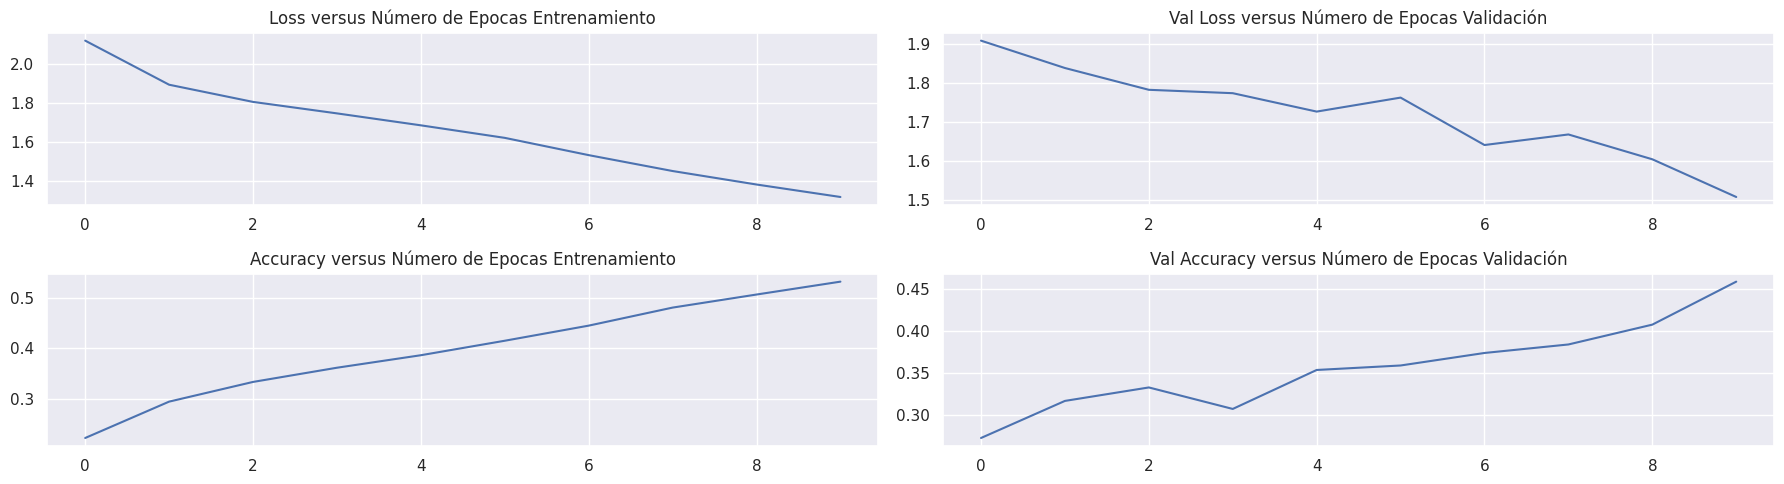

In [ ]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 2, figsize=(18,5))
axis[0,0].plot(history.history['loss'], label='train loss')
axis[0,1].plot(history.history['val_loss'], label='val loss')
axis[1,0].plot(history.history['accuracy'], label='train acc')
axis[1,1].plot(history.history['val_accuracy'], label='val acc')
axis[0,0].set_title("Loss versus Número de Epocas Entrenamiento")
axis[0,1].set_title("Val Loss versus Número de Epocas Validación")
axis[1,0].set_title("Accuracy versus Número de Epocas Entrenamiento")
axis[1,1].set_title("Val Accuracy versus Número de Epocas Validación")
plt.tight_layout()
plt.show()

RESPUESTA: Se puede ver que este tiene overfitting a partir de cierta epoca, lo cual implica un rendimiento mas bajo en los datos de validación. Sin embargo se puede notar que la tendencia general es a mejorar con mayor número de épocas (de lo que se puede ver)

* *Evalúe el modelo sobre el conjunto de pruebas. ¿Anticipa el error de entrenamiento final el desempeño obtenido sobre el conjunto de pruebas? ¿Anticipa el error de validación final el desempeño obtenido sobre el conjunto de pruebas? Concluya.*

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

def get_accuracy(model,dataset):
  return model.evaluate(dataset,verbose=0)[1]

test_data_preprocessed = test_data.map(preprocess)
print("Accuracy Entrenamiento:", get_accuracy(model_base,train_data_preprocessed))
print("Accuracy Validación:", get_accuracy(model_base,val_data_preprocessed))
print("Accuracy Pruebas:", get_accuracy(model_base,test_data_preprocessed))

Accuracy Entrenamiento: 0.5756863355636597
Accuracy Validación: 0.4440993666648865
Accuracy Pruebas: 0.43310847878456116


RSPUESTAS: 
* a) ¿Anticipa el error de entrenamiento final el desempeño obtenido sobre el conjunto de pruebas?:
- Respuesta: No tiene porque ser necesariamente así, pues aunque el error de los datos de entrenamiento sea una medida útil en ciertos casos, hay que considerar que el modelo podría presentar overfitting, lo cual implicaria que el error en los datos de prueba es mayor. Es por esto que en realidad no es un buen indicador.
* b) ¿Anticipa el error de validación final el desempeño obtenido sobre el conjunto de pruebas?:
- Respuesta: Se podría decir que mas o menos si, puesto que el error de los datos de validación permite detectar el overfitting al comparar con los resultados de datos nuevos. Pero aun así si estos fueran considerablemente distintos a los de pruebas también podría fallar respecto de lo afirmado.

En conclusión, el error de validación suele ser mejor indicador que el error de entrenamiento.


* *¿Es parejo el rendimiento del modelo entre las diferentes clases? ¿Qué clases se confunden más entre sí?*

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

def get_report(model,dataset):
  y_pred = []
  y_true = []
  for image_batch, label_batch in dataset:
    y_true.append(tf.argmax(label_batch,axis=-1))
    preds = model.predict(image_batch,verbose=0)
    y_pred.append(np.argmax(preds,axis=-1))
  correct_labels = tf.concat([item for item in y_true], axis=0)
  predicted_labels = tf.concat([item for item in y_pred], axis=0)
  cf = classification_report(correct_labels, predicted_labels, target_names=label_list)
  return cf

print("Classification Report Entrenamiento")
print(get_report(model_base,train_data_preprocessed ))
print("Classification Report Validación")
print(get_report(model_base,val_data_preprocessed ))
print("Classification Report Pruebas")
print(get_report(model_base,test_data_preprocessed ))

Classification Report Entrenamiento
                            precision    recall  f1-score   support

   Disk_Edge-on_Boxy_Bulge       0.40      0.64      0.49      1225
     Disk_Edge-on_No_Bulge       0.86      0.10      0.18      1097
Disk_Edge-on_Rounded_Bulge       0.82      0.04      0.09       200
 Disk_Face-on_Loose_Spiral       0.73      0.83      0.78      1123
Disk_Face-on_Medium_Spiral       0.85      0.87      0.86       853
    Disk_Face-on_No_Spiral       0.56      0.05      0.10       648
 Disk_Face-on_Tight_Spiral       0.49      0.65      0.56      1576
       Smooth_Cigar_shaped       0.78      0.48      0.59      1216
   Smooth_Completely_round       0.44      0.59      0.50      1111
   Smooth_in-between_round       0.63      0.78      0.70      1587

                  accuracy                           0.58     10636
                 macro avg       0.66      0.50      0.48     10636
              weighted avg       0.63      0.58      0.54     10636

Classific

RESPUESTA: El rendimiento entre las clases no es parejo, puesto que existen diferencias marcadas de puntuación en algunos puntajes y estas suelen "mantenerse" entre los datos de entrenamiento, validación y prueba. Por otro lado, para ver las clases basta notar aquellas que tengan puntajes más parecidos y que además sean bajos.

# P3. Más Neuronas 

El objetivo de esta sección es que aprenda a controlar el número de neuronas en la red y entender sus posibles efectos.

* *¿Da lo mismo utilizar 128 neuronas en la capa oculta respecto de usar 16 o 512? ¿Qué se espera observar si hace estos cambios? Para verificarlo, entrene su modelo base con un número creciente de neuronas. Para esto no demore excesivamente, utilice el conjunto de entrenamiento pequeño incluido dentro de la carpeta de datos (reduced_train)*. 

In [ ]:
BATCH_SIZE = 32
train_data = load_data("/content/galaxies_INF395/reduced_train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("/content/galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
test_data = load_data("/content/galaxies_INF395/test/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
train_data_preprocessed = train_data.map(preprocess)
val_data_preprocessed = val_data.map(preprocess)
test_data_preprocessed = test_data.map(preprocess)

Found 536 files belonging to 10 classes.
Found 3542 files belonging to 10 classes.
Found 3558 files belonging to 10 classes.


Para este experimento, utilizaremos un "truco", usualmente muy útil, que consiste en detener el entrenamiento cuando no se observen mejoras por un determinado periodo de tiempo (paciencia). De este modo, podremos fijar un número relativamente grande de épocas (E=200) que aprovecharán probablemente los modelos más "grandes".

* *Verifique que los modelos más "pequeños" requieren menor optimización para alcanzar su punto de saturación sobre los datos de entrenamiento respecto de los modelos "grandes"* 

In [ ]:
from keras.callbacks import EarlyStopping
mc =  EarlyStopping(monitor='accuracy',min_delta=0,patience=10,restore_best_weights=True)

NUM_PIXELS = RES_ESPACIAL*RES_ESPACIAL*CHANNELS
NUM_CLASSES = 10

list_nneurons = [2, 16, 32, 64, 128, 256, 512]
train_accuracies = []
val_accuracies = []

for nneurons in list_nneurons:
  input = keras.Input(shape=(NUM_PIXELS))
  hidden_temp = Dense(nneurons, activation='relu')(input)  
  outputs_temp = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden_temp)
  model_temp = tf.keras.Model(inputs=input, outputs=outputs_temp) 
  model_temp.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
  print("NEURONS ", nneurons)
  history_temp = model_temp.fit(train_data_preprocessed, epochs=200, callbacks=[mc], verbose=0)
  train_accuracies.append(get_accuracy(model_temp,train_data_preprocessed))
  val_accuracies.append(get_accuracy(model_temp,val_data_preprocessed))


NEURONS  2
NEURONS  16
NEURONS  32
NEURONS  64
NEURONS  128
NEURONS  256
NEURONS  512


* *¿Mejora la capacidad predictiva del modelo a medida que se aumenta el número de neuronas en la capa oculta? ¿Aumenta la cantidad de parámetros entrenables*

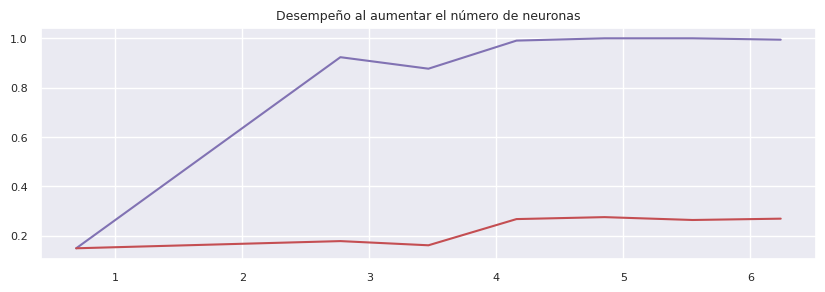

In [ ]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
p1 = plt.plot(np.log(list_nneurons),train_accuracies,color='m')
p2 = plt.plot(np.log(list_nneurons),val_accuracies,color='r')
plt.tick_params(labelsize=8)
ax.set_title('Desempeño al aumentar el número de neuronas',fontsize=9)
plt.xticks(rotation=0)
plt.show()

RESPUESTA: Según lo mostrado en el gráfico aparentemente si existe una correlación entre el desempeño y la cantidad de neuronas, pero a partir de cierto punto se estabiliza, lo cual ocurre antes con los datos de entrenamiento en este caso. Por otro lado, es lógico pensar que los parámetros entrenables también aumentan puesto que existe un mayor número de conexiones.

# P4. Modelo más Profundo

El objetivo de esta sección es que aprenda a controlar el número de capas en la red y entender sus posibles efectos.

* *Modifique el modelo base aumentando el número de capas ocultas. Si mantiene el mismo número total de neuronas ¿Aumenta o disminuye el número de parámetros entrenables? ¿Es esto conveniente desde un punto de vista computacional?* 

In [ ]:
from tensorflow.keras.layers import Dense

NUM_PIXELS = RES_ESPACIAL*RES_ESPACIAL*CHANNELS
NUM_CLASSES = 10
NUM_NEURONS_BASE = 512

def profundo(OCULTAS = 2):
  input_temp = keras.Input(shape=(NUM_PIXELS))
  hidden_temp = Dense(NUM_NEURONS_BASE//OCULTAS, activation='relu')(input_temp)
  for i in range(OCULTAS-1):
    hidden_temp = Dense(NUM_NEURONS_BASE//OCULTAS, activation='relu')(hidden_temp) 
  outputs_temp = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(hidden_temp)
  model_temp = tf.keras.Model(inputs=input_temp, outputs=outputs_temp) 
  return model_temp 
model_2 = profundo(OCULTAS = 2)
model_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 12288)]           0         
                                                                 
 dense_16 (Dense)            (None, 256)               3145984   
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (None, 10)                2570      
                                                                 
Total params: 3,214,346
Trainable params: 3,214,346
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
mc =  EarlyStopping(monitor='accuracy',min_delta=0,patience=10,restore_best_weights=True)

profundidades = [1,2,4,8]
train_accuracies_prof = []
val_accuracies_prof = []

for p in profundidades:
  model_temp = profundo(OCULTAS = p)
  print("PROFUNDIDAD ", p)
  model_temp.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
  history_temp = model_temp.fit(train_data_preprocessed, epochs=200, callbacks=[mc], verbose=0)
  train_accuracies_prof.append(get_accuracy(model_temp,train_data_preprocessed))
  val_accuracies_prof.append(get_accuracy(model_temp,val_data_preprocessed))


PROFUNDIDAD  1
PROFUNDIDAD  2
PROFUNDIDAD  4
PROFUNDIDAD  8


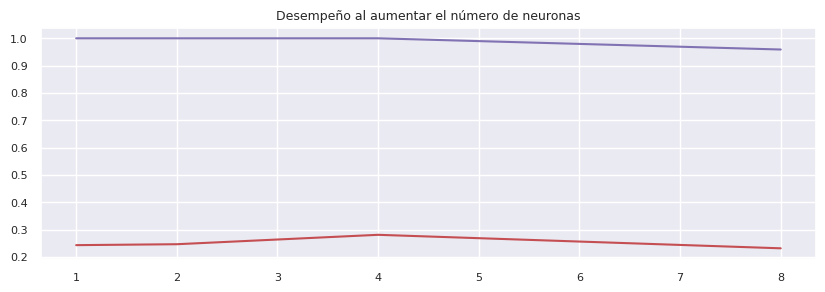

In [ ]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
p1 = plt.plot(profundidades,train_accuracies_prof,color='m')
p2 = plt.plot(profundidades,val_accuracies_prof,color='r')  
plt.tick_params(labelsize=8)
ax.set_title('Desempeño al aumentar el número de neuronas',fontsize=9)
plt.xticks(rotation=0)
plt.show()

In [ ]:
test_data_preprocessed = test_data.map(preprocess)
model_2.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
print("Accuracy Entrenamiento MODEL 2:", get_accuracy(model_2,train_data_preprocessed))
print("Accuracy Validación MODEL 2:", get_accuracy(model_2,val_data_preprocessed))
print("Accuracy Pruebas MODEL 2:", get_accuracy(model_2,test_data_preprocessed))

Accuracy Entrenamiento MODEL 2: 0.10447761416435242
Accuracy Validación MODEL 2: 0.10333145409822464
Accuracy Pruebas MODEL 2: 0.1028667762875557


In [ ]:
print("Classification Report Entrenamiento MODEL 2")
print(get_report(model_2,train_data_preprocessed ))
print("Classification Report Validación MODEL 2")
print(get_report(model_2,val_data_preprocessed ))
print("Classification Report Pruebas MODEL 2")
print(get_report(model_2,test_data_preprocessed ))

Classification Report Entrenamiento MODEL 2


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

   Disk_Edge-on_Boxy_Bulge       0.00      0.00      0.00        62
     Disk_Edge-on_No_Bulge       0.00      0.00      0.00        55
Disk_Edge-on_Rounded_Bulge       0.00      0.00      0.00        10
 Disk_Face-on_Loose_Spiral       1.00      0.02      0.03        57
Disk_Face-on_Medium_Spiral       0.00      0.00      0.00        43
    Disk_Face-on_No_Spiral       0.00      0.00      0.00        33
 Disk_Face-on_Tight_Spiral       0.00      0.00      0.00        79
       Smooth_Cigar_shaped       0.00      0.00      0.00        61
   Smooth_Completely_round       0.10      0.98      0.19        56
   Smooth_in-between_round       0.00      0.00      0.00        80

                  accuracy                           0.10       536
                 macro avg       0.11      0.10      0.02       536
              weighted avg       0.12      0.10      0.02       536

Classification Report Validación MODEL 2


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

   Disk_Edge-on_Boxy_Bulge       0.00      0.00      0.00       408
     Disk_Edge-on_No_Bulge       0.00      0.00      0.00       365
Disk_Edge-on_Rounded_Bulge       0.07      0.02      0.03        66
 Disk_Face-on_Loose_Spiral       0.00      0.00      0.00       374
Disk_Face-on_Medium_Spiral       0.00      0.00      0.00       284
    Disk_Face-on_No_Spiral       0.00      0.00      0.00       216
 Disk_Face-on_Tight_Spiral       0.12      0.00      0.00       525
       Smooth_Cigar_shaped       0.00      0.00      0.00       405
   Smooth_Completely_round       0.10      0.98      0.19       370
   Smooth_in-between_round       0.08      0.00      0.00       529

                  accuracy                           0.10      3542
                 macro avg       0.04      0.10      0.02      3542
              weighted avg       0.04      0.10      0.02      3542

Classification Report Pruebas MODEL 2
       

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RESPUESTA: Para este caso, vimos que la cantidad de parámetros entrenables disminuyó (porque con 1 capa oculta tenía más parámetros). Por otro lado, no sabriamos decir si computacionalmente es mas o menos costoso puesto que si bien la cantidad de parámetros entrenables se redujeron, también la complejidad del modelo aumenta.

# P5. Detalles de Entrenamiento

El objetivo de esta sección es que aprenda a controlar algunos hiper-parámetros importantes del entrenamiento como el tamaño de batch, el número de épocas, y la tasa de aprendizaje.

* *Determine si al aumentar/reducir el tamaño de batch, aumenta/reduce los tiempos de entrenamiento. Determine también si al aumentar/reducir el tamaño de batch, el modelo aprende más rápido/lento, definiendo claramente cómo medira la "velocidad de aprendizaje". Para este estudio, evalue sólo 2 a 4 cambios sobre el modelo, pero calibre los cambios de modo de observar un efecto significativo (por ejemplo, al cambiar de 32 a 30 no se espera gran cambio).*

* *Determine si al aumentar el número de épocas totales el modelo efectivamente aprende más.  Para este estudio, evalue sólo 1 cambio a un número signitivamente más grande de épocas, monitoreando las métricas importantes. Razone a partie de un gráfico del tipo métrica versus época de entrenamiento.*

* *La teoría prevé que con tasas de aprendizaje excesivamente grandes, existe riesgo de divergencia, mientras que con tasas de aprendizaje excesivamente pequeñas el entrenamiento es muy lento. Verifique experimentalmente estas predicciones, utilizando para el entrenamiento SGD con tasa fija.*

1) Primero verificamos el primer inciso

In [ ]:
from keras.models import Model
from keras.layers import Dense, Input
from keras.optimizers import SGD
import time

NUM_PIXELS = RES_ESPACIAL * RES_ESPACIAL * CHANNELS
NUM_CLASSES = 10
NUM_NEURONS = 128

batch_sizes = [16, 32, 64]
times = []

for batch_size in batch_sizes:
    input = Input(shape=(NUM_PIXELS,))
    hidden = Dense(NUM_NEURONS, activation="relu")(input)
    outputs = Dense(NUM_CLASSES, activation="softmax")(hidden)
    model = Model(inputs=input, outputs=outputs)
    optimizer = SGD(learning_rate=1.0)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    start_time = time.time()
    model.fit(train_data_preprocessed, epochs=10, batch_size=batch_size, verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    times.append(training_time)
    print("Batch size: {}, Tiempo de entrenamiento: {} segundos".format(batch_size, training_time))

RESPUESTA: Al parecer, el tiempo suele ir disminución (PENDIENTE)

2) Ahora verificamos el segundo inciso (OJO)

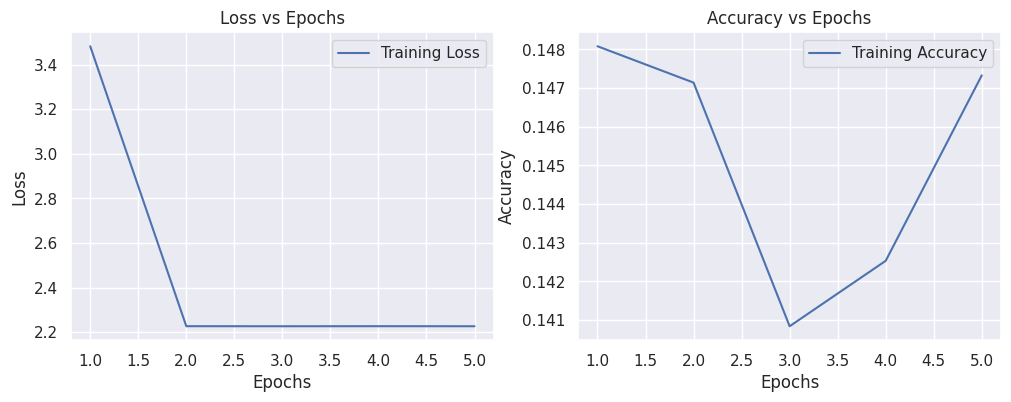

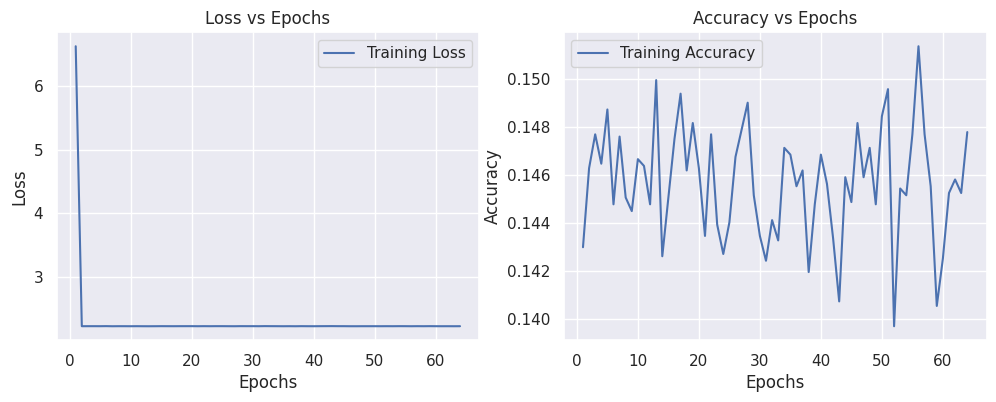

In [ ]:
epocas = [5, 64]

for epoca in epocas:
    input = keras.Input(shape=(NUM_PIXELS))
    hidden = Dense(NUM_NEURONS, activation="relu")(input)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(hidden)
    model_base = tf.keras.Model(inputs=input, outputs=outputs)
    optimizer = SGD(learning_rate=1.0)
    model_base.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model_base.fit(train_data_preprocessed, epochs=epoca, batch_size=batch_size, verbose=0)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(range(1, epoca+1), history.history['loss'], 'b-', label='Training Loss')
    axs[0].set_title('Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(range(1, epoca+1), history.history['accuracy'], 'b-', label='Training Accuracy')
    axs[1].set_title('Accuracy vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

In [ ]:
tasas = [0.2, 5]

for tasa in tasas:
    input = keras.Input(shape=(NUM_PIXELS))
    hidden = Dense(NUM_NEURONS, activation="relu")(input)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(hidden)
    model_base = tf.keras.Model(inputs=input, outputs=outputs)
    optimizer = SGD(learning_rate=tasa)
    model_base.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model_base.fit(train_data_preprocessed, epochs=10, batch_size=batch_size, verbose=0)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(range(1, epoca+1), history.history['loss'], 'b-', label='Training Loss')
    axs[0].set_title('Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(range(1, epoca+1), history.history['accuracy'], 'b-', label='Training Accuracy')
    axs[1].set_title('Accuracy vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()

# P6. Modelo Especializado

El objetivo de esta sección es que aprenda a combinar trozos de redes posiblemente entrenadas por otros con trozos propios para su problema. Para ello, construiremos una serie de capas especializadas en visión, que estudiaremos próximamente. Por ahora, utilice esta serie capas como una caja negra que extrae características para su modelo denso tradicional.

* *¿Qué recibe como input este modelo visual?*

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Rescaling, Flatten, GlobalAveragePooling2D

########## MODELO VISUAL ESPECIALIZADO (lo estudiaremos pronto) ##########
image_raw = keras.Input(shape=(RES_ESPACIAL,RES_ESPACIAL,CHANNELS))
image_scaled = Rescaling(scale=1/255.0)(image_raw)
visual = Conv2D(32,(3,3),activation='relu',padding='same')(image_scaled)
visual = Conv2D(32,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
visual = Conv2D(64,(3,3),activation='relu',padding='same')(visual)
visual = MaxPooling2D(pool_size=(2,2))(visual)
visual = Conv2D(128,(3,3),activation='relu',padding='same')(visual)
features = GlobalAveragePooling2D()(visual)

model_visual = tf.keras.Model(inputs=image_raw, outputs=features) 
model_visual.summary()


* *Defina una red similar a la del modelo base, pero que se alimente de las características extraídas desde la red especializada definida más arriba. ¿De qué tamaño es el input de la parte que contruye sobre el modelo anterior? ¿Cómo se ensamblan las dos piezas? ¿Qué trozo tiene más parámetros libres?*

In [ ]:
########## PARTE DENSA TRADICIONAL ##########
hidden =  Dense(256, activation='relu')(model_visual.output)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
trozo_nuevo = tf.keras.Model(inputs=model_visual.output, outputs=outputs)  
trozo_nuevo.summary()

########## ENSAMBLAMOS LAS PIEZAS ##########
model_combinado = tf.keras.Model(inputs=model_visual.input, outputs=outputs)  
model_combinado.summary()

## Entrenamiento 

* *Intente entrenar el modelo completo por unas 30 épocas. Si no lo consigue intente cambios que se lo permitan como por ejemplo: reducir la resolución de las imágenes, reducir el número de épocas, o trabajar con la colección pequeña de entrenamiento.*

In [ ]:
BATCH_SIZE = 32
RES_ESPACIAL = 64
train_data = load_data("/content/galaxies_INF395/train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("/content/galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
test_data = load_data("/content/galaxies_INF395/test/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)

In [ ]:
optimizer = Adam()
model_combinado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_combinado = model_combinado.fit(train_data, epochs=30, validation_data=val_data)

* *¿Aprende mejor este modelo? ¿Generaliza mejor?*

In [ ]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 2, figsize=(18,5))
axis[0,0].plot(history_combinado.history['loss'], label='train loss')
axis[0,1].plot(history_combinado.history['val_loss'], label='val loss')
axis[1,0].plot(history_combinado.history['accuracy'], label='train acc')
axis[1,1].plot(history_combinado.history['val_accuracy'], label='val acc')
axis[0,0].set_title("Loss versus Número de Epocas Entrenamiento")
axis[0,1].set_title("Val Loss versus Número de Epocas Validación")
axis[1,0].set_title("Accuracy versus Número de Epocas Entrenamiento")
axis[1,1].set_title("Val Accuracy versus Número de Epocas Validación")
plt.tight_layout()
plt.show()

* *¿Mejora el desempeño de las clases de galaxia peor detectadas por el modelo denso de partida?*

In [ ]:
print("Classification Report Entrenamiento MODELO COMBINADO")
print(get_report(model_combinado,train_data))
print("Classification Report Validación MODELO COMBINADO")
print(get_report(model_combinado,val_data))
print("Classification Report Pruebas MODELO COMBINADO")
print(get_report(model_combinado,test_data))

## Guardar (Opcional)

El código de más abajo guarda la parte del modelo anterior que extrae características visuales. Si usted entrenó un modelo con buen desempeño puede valer la pena ejecutar este paso.


In [ ]:
#Esto guarda la parte del modelo anterior que extrae características visuales
model_visual = tf.keras.Model(inputs=image_raw, outputs=features) 
model_visual.summary()
model_visual.save('modelo_visual_entrenado_nombre_elegido.h5')

# P7. Modelo Recargado

El objetivo de esta sección es que aprenda a cargar un modelo entrenado y salvado por otra persona (posiblemente un compañero de equipo) para iniciar un entrenamiento fino o un uso nuevo de las características aprendidas.



* *Cargue el modelo entrenado distribuido con esta tarea y úselo para crear un nuevo modelo combinado similar al anterior. ¿Cuántos parámetros tiene el modelo que cargó?*

In [ ]:
#OMITIR ESTA LÍNEA SI CARGÓ EL ARCHIVO DIRECTAMENTE EN LA MÁQUINA VIRTUAL
#O BIEN ADÁPTELA AL PATH DE SU REPOSITORIO EN LA NUBE
!cp "/content/drive/My Drive/Taller1-B/modelo_visual_entrenado.h5" .

In [ ]:
#ESTO CARGA UN MODELO VISUAL YA ENTRENADO DECLARANDOLO NO ENTRENABLE
mi_modelo_visual = keras.models.load_model('modelo_visual_entrenado.h5')
mi_modelo_visual.trainable = False
mi_modelo_visual.summary()

In [ ]:
#ESTO EXTIENDE EL MODELO ANTERIOR CON CAPAS NUEVAS ENTRENABLES
hidden =  Dense(256, activation='relu')(mi_modelo_visual.output)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
model_recargado = tf.keras.Model(inputs=mi_modelo_visual.input, outputs=outputs) 

* *¿Cuántos parámetros entrenables tiene el modelo combinado creado? ¿Coincide con la suma de las dos partes? ¿Porqué?*

In [ ]:
model_recargado.summary()

In [ ]:
optimizer = Adam()
model_recargado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_recargado = model_recargado.fit(train_data, epochs=20, validation_data=val_data)

* *¿Aprende mejor este modelo respecto de los modelos que entrenó anteriormente? ¿Generaliza mejor?*

In [ ]:
print("Accuracy Entrenamiento MODELO RECARGADO:", get_accuracy(model_recargado,train_data))
print("Accuracy Validación MODELO RECARGADO:", get_accuracy(model_recargado,val_data))
print("Accuracy Pruebas MODELO RECARGADO:", get_accuracy(model_recargado,test_data))

print("Classification Report Entrenamiento MODEL ESPECIALIZADO")
print(get_report(model_recargado,train_data))
print("Classification Report Validación MODEL ESPECIALIZADO")
print(get_report(model_recargado,val_data))
print("Classification Report Pruebas MODEL ESPECIALIZADO")
print(get_report(model_recargado,test_data))

## Pre-procesando los datos.

Si por razones computacionales, no puede entrenar el modelo recargado, una opción es aplicarlo a los datos antes de cualquier entrenamiento y definir solo el trozo extra.

In [ ]:
def preprocess_visual(x,y):
  return mi_modelo_visual(x),y

train_data_visual_features = train_data.map(preprocess_visual)
val_data_visual_features = val_data.map(preprocess_visual)

In [ ]:
#for x,y in train_data_visual_features:
#  print(x.numpy().shape,y.numpy().shape)

In [ ]:
N_VISUAL_FEATURES=128
NUM_CLASSES=10
image_preprocesada = keras.Input(shape=(N_VISUAL_FEATURES))
hidden =  Dense(256, activation='relu')(image_preprocesada)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
model_recargado_preprocesado = tf.keras.Model(inputs=image_preprocesada, outputs=outputs) 

In [ ]:
optimizer = Adam()
model_recargado_preprocesado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history_recargado_preprocesado = model_recargado_preprocesado.fit(train_data_visual_features, epochs=2, validation_data=val_data_visual_features)

* *Determine si disminuyendo/aumentando el número de neuronas ocultas del modelo construido más arriba (256 unidades ocultas), se deteriora/mejora la capacidad predictiva del modelo. Investigue también si agregando capas ocultas extras obtiene mejores resultados. *

In [ ]:
from keras.callbacks import EarlyStopping
mc =  EarlyStopping(monitor='accuracy',min_delta=0.01,patience=10,restore_best_weights=True)
N_VISUAL_FEATURES=128

list_nneurons_recargado = [2, 256, 1024]
train_accuracies_recargado = []
val_accuracies_recargado = []

for nneurons in list_nneurons:
  image_preprocesada = keras.Input(shape=(N_VISUAL_FEATURES))
  hidden =  Dense(nneurons, activation='relu')(image_preprocesada)
  outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
  model_recargado_preprocesado = tf.keras.Model(inputs=image_preprocesada, outputs=outputs) 
  model_recargado_preprocesado.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  history_recargado_preprocesado = model_recargado_preprocesado.fit(train_data_visual_features, callbacks=[mc], epochs=2, verbose=0)
  train_accuracies_recargado.append(get_accuracy(model_recargado_preprocesado,train_data_visual_features))
  val_accuracies_recargado.append(get_accuracy(model_recargado_preprocesado,val_data_visual_features ))


In [ ]:
fig, ax = plt.subplots(figsize=(10,3),nrows=1)
p1 = plt.plot(np.log(list_nneurons_recargado),train_accuracies_recargado,color='m')
p2 = plt.plot(np.log(list_nneurons_recargado),val_accuracies_recargado,color='m')
b.tick_params(labelsize=9)
ax.set_title('Desempeño al aumentar el número de neuronas',fontsize=10)
plt.xticks(rotation=0)
plt.show()

# P8. Embeddings

El objetivo de esta sección es que explore las características que aprende la red. En el caso de que su modelo tenga 1 capa oculta de M neuronas, podemos "proyectar" esas M características en el plano para visualizar si las clases se separan correctamente o no. Una técnica para hacer esto es TSNE. 

* *Determine visualmente si las características que aprende su modelo son mejores que las características originales de las imágenes (pixeles) para separar las diferentes clases de galaxias. Como modelo, utilice el que construimos en P7 usando el modelo recargado.*

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
#Funcion que extrae explícitamente arreglos de datos desde un Dataset "virtual".
#reducir "limitar2 si tiene muchos problemas de memoria

def get_XY(TFdataset,limitar=100000000):
  features = []
  etiquetas = []
  counter=0
  for x,y in TFdataset: 
    features.append(x.numpy())
    etiquetas.append(y.numpy())
    if counter>limitar:
      break
    counter+=1
  X = np.vstack(features)
  y = np.vstack(etiquetas)
  return X,y

In [ ]:
def preprocess(x,y):#esto escala y transforma las imagenes en vectores
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return tf.reshape(normalization_layer(x),(-1,RES_ESPACIAL*RES_ESPACIAL*CHANNELS)),y

train_data_preprocessed = train_data.map(preprocess)
X, y = get_XY(train_data_preprocessed,1000)
X_embedded_original = TSNE(n_components=2).fit_transform(X)
print(X.shape, " ===> ", X_embedded_original.shape)

In [ ]:
def scaleonly(x,y):#esto es para escalar las caracteristicas extraidas por el modelo
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return normalization_layer(x),y


In [ ]:
#train_data_visual_features fue obtenido en P7.
train_data_visual_features = train_data_visual_features.map(scaleonly)
Xv, yv = get_XY(train_data_visual_features,1000)
print(Xv.shape)
X_embedded_visual = TSNE(n_components=2).fit_transform(Xv)
print(Xv.shape, " ===> ", X_embedded_visual.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1,ncols=2)
ax[0].scatter(X_embedded_original[:,0],X_embedded_original[:,1],c=np.argmax(y,axis=1),s=1)
ax[1].scatter(X_embedded_visual[:,0],X_embedded_visual[:,1],c=np.argmax(yv,axis=1),s=1)
plt.show()

* *Determine si aumentando la profundidad de su modelo, se obtienen mejores características.*

In [ ]:
N_VISUAL_FEATURES=128
NUM_CLASSES = 10
image_preprocesada = keras.Input(shape=(N_VISUAL_FEATURES))
hidden =  Dense(256, activation='relu')(image_preprocesada)
hidden =  Dense(128, activation='relu')(hidden)
outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
model_recargado_profundo = tf.keras.Model(inputs=image_preprocesada, outputs=outputs) 
model_recargado_profundo.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history_recargado_profundo = model_recargado_profundo.fit(train_data_visual_features, epochs=10)


In [ ]:
from keras import backend as K

def extrae_una_capa(x,y):
  return embedding_function(x),y

capa_interes = 0
embedding_function = tf.keras.Model(inputs=model_recargado_profundo.input, outputs=model_recargado_profundo.layers[capa_interes].output) 

train_data_deep_features = train_data_visual_features.map(extrae_una_capa)


In [ ]:
train_data_deep_features = train_data_deep_features.map(scaleonly)
Xd, yd = get_XY(train_data_deep_features,1000)
print(Xd.shape)
X_embedded_deep = TSNE(n_components=2).fit_transform(Xd)
print(Xd.shape, " ===> ", X_embedded_deep.shape)

In [ ]:
def extrae_una_capa2(x,y):
  return embedding_function2(x),y

capa_interes2 = 1
embedding_function2 = tf.keras.Model(inputs=model_recargado_profundo.input, outputs=model_recargado_profundo.layers[capa_interes2].output) 

train_data_deep_features2 = train_data_visual_features.map(extrae_una_capa2)


In [ ]:
train_data_deep_features2 = train_data_deep_features2.map(scaleonly)
Xd2, yd2 = get_XY(train_data_deep_features2,1000)
print(Xd2.shape)
X_embedded_deep2 = TSNE(n_components=2).fit_transform(Xd2)
print(Xd2.shape, " ===> ", X_embedded_deep2.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1,ncols=2)
ax[0].scatter(X_embedded_deep[:,0],X_embedded_deep[:,1],c=np.argmax(yv,axis=1),s=1)
ax[1].scatter(X_embedded_deep2[:,0],X_embedded_deep2[:,1],c=np.argmax(yd,axis=1),s=1)
plt.show()

* *Para finalizar esta sección, se le pide proponer una forma de aprovechar los embeddings extraidos por su red. Imagine que sólo dispone de ellos y que debe inventarse un modo de clasificar imágenes con ellos. Proponga e implemente un método sencillo que no requiera entrenar una red neuronal.*

# P9. Creando Más Data

* *El objetivo de esta sección es que aprenda a generar imágenes artificiales para aumentar el conjunto de entrenamiento. Para ello usaremos generadores. Comience averiguando qué hace la clase "ImageDataGenerator" utilizada más abajo y en qué escenarios esto podría ayudar a obtener mejores resultados.*

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        "/content/galaxies_INF395/train/",
        target_size=(RES_ESPACIAL,RES_ESPACIAL),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        "/content/galaxies_INF395/val/",
        target_size=(RES_ESPACIAL,RES_ESPACIAL),
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode='categorical')


* *Replicando alguna de las técnicas utilizadas en P7 (extensión del modelo o pre-procesamiento usando modelo pre-entrenado), determine si generar imágenes "virtuales" mejora los resultados del reconocedor de galaxias.*

In [ ]:
#ESTO CARGA UN MODELO VISUAL YA ENTRENADO DECLARANDOLO NO ENTRENABLE
mi_modelo_visual = keras.models.load_model('modelo_visual_entrenado.h5')
mi_modelo_visual.trainable = False

hidden_aumentado =  Dense(256, activation='relu')(mi_modelo_visual.output)
outputs_aumentado = Dense(NUM_CLASSES, activation='softmax')(hidden_aumentado)
model_aumentado = tf.keras.Model(inputs=mi_modelo_visual.input, outputs=outputs_aumentado) 
model_aumentado.summary()


In [ ]:
model_aumentado.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history_aumentado = model_aumentado.fit(train_generator, epochs=10, validation_data=validation_generator)


* *Si su respuesta a la pregunta anterior fue negativa y tiene la capacidad de entrenar el modelo visual, determine si, haciendo este cambio, cambia su respuesta.*

# P10. Hyper-tuneo

El objetivo de esta sección es que aprenda a seleccionar algunos hyper-parámetros importantes de la arquitectura de la red. El objetivo no es que obtenga una super red, sino que entienda cómo hacer correctamente esto en el futuro.

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt
from tensorflow import keras

In [ ]:
redtrain_data = load_data("/content/galaxies_INF395/reduced_train/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
val_data = load_data("/content/galaxies_INF395/val/",batch_size=BATCH_SIZE, res=RES_ESPACIAL)
redtrain_data_visual_features = redtrain_data.map(preprocess_visual)
val_data_visual_features = val_data.map(preprocess_visual)



*   *Utilice la herramienta anterior para definir una estrategia que determine el número de capas, número de neuronas, y learning rate. Expliqué qué métrica monitorearía y sobre qué conjunto de datos. ¿Tiene sentido hacerlo sobre los datos de entrenamiento o es más correcto hacerlo sobre los datos de validación? Porqué? Pruebe su implementación usando un número de ,muy reducido de épocas de entrenamiento sólo para chequear que obtiene el resultado esperado.*


In [ ]:
from tensorflow.keras.layers import Dense

N_VISUAL_FEATURES=128
NUM_CLASSES=10

def modelo_a_tunear(tuner):
  input = keras.Input(shape=(N_VISUAL_FEATURES))
  for i in range(1, tuner.Int("num_layers", 2, 3)):
    if i==1:
      x = Dense(units=tuner.Int("units_" + str(i), min_value=32, max_value=64, step=32),
              activation='relu')(input)
    else:
      x = Dense(units=tuner.Int("units_" + str(i), min_value=32, max_value=64, step=32),
              activation='relu')(x)
  outputs_tunner = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
  model_tunner = tf.keras.Model(inputs=input, outputs=outputs_tunner) 
  learning_rate_tuneada = tuner.Choice("learning_rate", values=[1e-1, 1e-2])
  model_tunner.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_tuneada),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])
  return model_tunner


In [ ]:
hypertuner = kt.Hyperband(modelo_a_tunear,
                     objective='val_accuracy',
                     max_epochs=2,
                     factor=3,
                     directory='.',
                     project_name='taller1')


In [ ]:
!ls

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

hypertuner.search(redtrain_data_visual_features, epochs=2, validation_data=val_data_visual_features, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=hypertuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Comentarios Finales

A modo de conclusión, comente que es lo más interesante que aprendió del taller.